In [1]:
# Gitcloning the data

!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 5.69 MiB/s, done.
ls: cannot access 'german-traffic-sign': No such file or directory


In [2]:
# Importing the important libraries

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
%matplotlib inline

In [3]:
# Loading the data

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
# Spliting out features and labels

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [5]:
#Extracting the dimensions of the data

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [6]:
# Assertion to check if our data is correct. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [7]:
# Creating a dataframe from the CSV file
data = pd.read_csv('german-traffic-signs/signnames.csv')


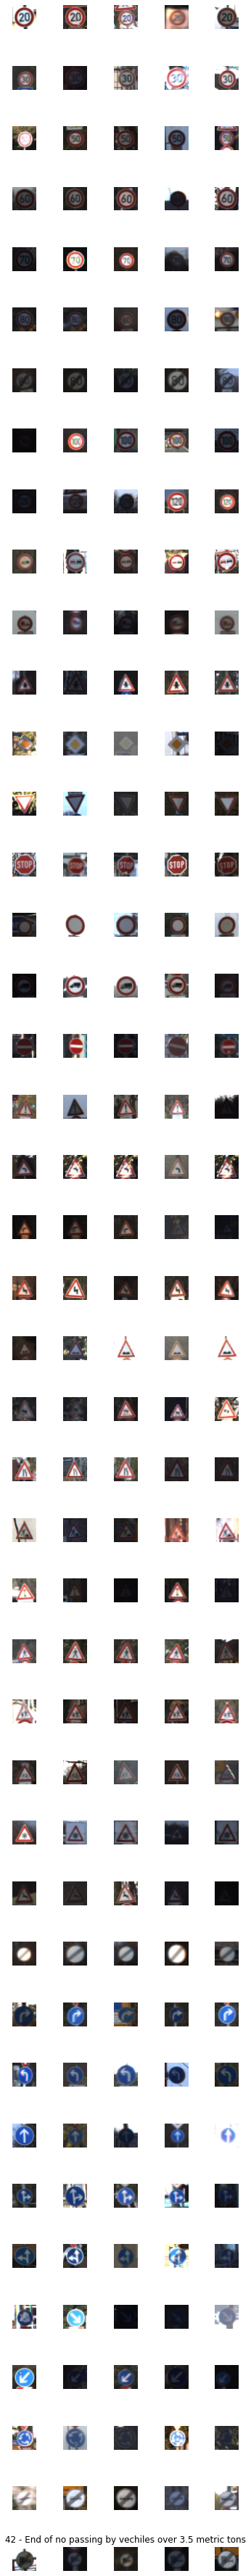

In [10]:
# Displaying 5 random samples of all 43 classes

num_of_samples=[]
 
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
    if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[210]


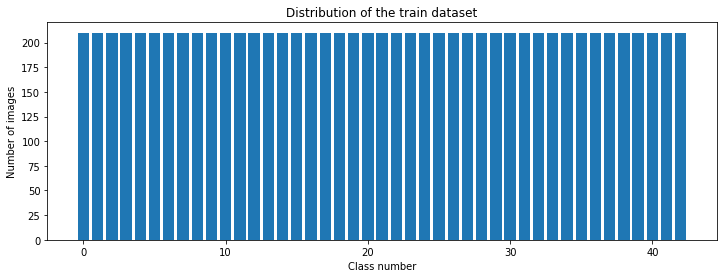

In [34]:
print(num_of_samples)

plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


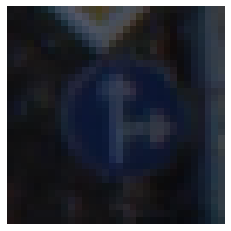

In [12]:
# Displaying random image, shape and its corresponding label

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


(32, 32)


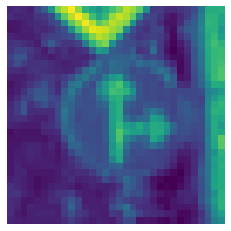

In [13]:
# Function to convert RGB image into grayscale image
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# Verifing the function
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


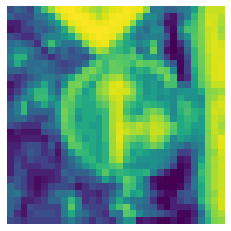

In [14]:
# Function to equalise the image pixel intensities
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

# Verifing the function
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [15]:
# Combined function of both the image processing fuction - grayscale and equalise

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [16]:
# Implementing the function on the entire dataset

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


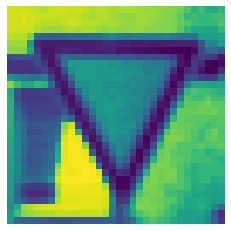

In [17]:
# Randomly verifing the image from the dataset

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [18]:
# Reshaping the image to introduce the channel

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

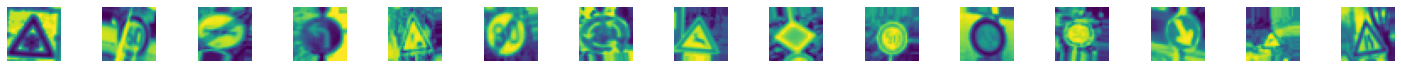

In [19]:
# Implementing Dataaugumentation to increase datasize

from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 


In [20]:
# Printing the shape of the batches generated above
print(X_batch.shape)

(15, 32, 32, 1)


In [21]:
# Applying one-hot encoding for multiclass-classification problem

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [22]:
# Creating Deep neural network model

def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
# Loading the model
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch= len(X_train)//50,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

<ipython-input-28-5e031800f07a>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


695/695 [==============================] - 16s 22ms/step - loss: 1.7145 - accuracy: 0.5112 - val_loss: 0.2991 - val_accuracy: 0.9102
Epoch 2/10
695/695 [==============================] - 15s 21ms/step - loss: 0.5253 - accuracy: 0.8383 - val_loss: 0.1481 - val_accuracy: 0.9506
Epoch 3/10
695/695 [==============================] - 15s 21ms/step - loss: 0.3090 - accuracy: 0.9034 - val_loss: 0.0892 - val_accuracy: 0.9732
Epoch 4/10
695/695 [==============================] - 15s 21ms/step - loss: 0.2240 - accuracy: 0.9306 - val_loss: 0.0813 - val_accuracy: 0.9732
Epoch 5/10
695/695 [==============================] - 15s 21ms/step - loss: 0.1842 - accuracy: 0.9439 - val_loss: 0.0504 - val_accuracy: 0.9878
Epoch 6/10
695/695 [==============================] - 15s 22ms/step - loss: 0.1560 - accuracy: 0.9524 - val_loss: 0.0413 - val_accuracy: 0.9875
Epoch 7/10
695/695 [==============================] - 15s 21ms/step - loss: 0.1434 - accuracy: 0.9567 - val_loss: 0.1147 - val_accuracy: 0.9694
Epo

Text(0.5, 0, 'epoch')

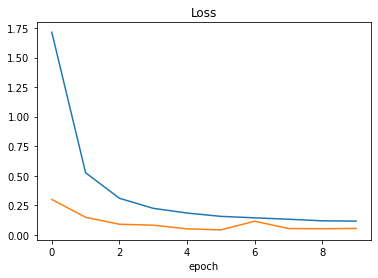

In [29]:
# Plotting the graph between training loss and cross-validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')



Text(0.5, 0, 'epoch')

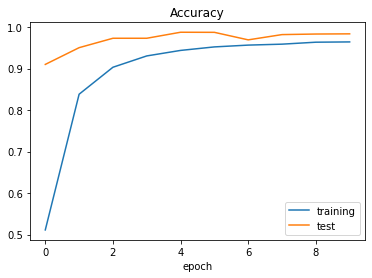

In [32]:
# Plotting the graph between training accuracy and cross-validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [33]:
# Evaluat model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.09886868298053741
Test accuracy: 0.9733175039291382
